In [32]:
import psycopg2
ASOS = psycopg2.connect(database='asos', host='mesonet.agron.iastate.edu', user='nobody')
cursor = ASOS.cursor()

cursor.execute("""
 select distinct date(valid) from alldata where station = 'OMA' 
 and sknt * 1.15 >= 25 and 
 extract(hour from ((valid + '10 minutes'::interval) at time zone 'UTC')) = 0
 and extract(month from valid) in (12,1,2) ORDER by date ASC
""")
wdates = []
for row in cursor:
    wdates.append( row[0] )
    
ASOS.close()
print len(wdates)

151


In [3]:
import psycopg2
POSTGIS = psycopg2.connect(database='postgis', host='mesonet.agron.iastate.edu', user='nobody')
cursor = POSTGIS.cursor()

cursor.execute("""
 select f.valid, p.smps, p.height from raob_profile p JOIN raob_flights f on (p.fid = f.fid) 
 WHERE f.station in ('KOAX','KOMA','KOVN') and p.smps * 2.23 > 30 and p.levelcode = 9 
 and extract(hour from f.valid at time zone 'UTC') = 0 ORDER by valid DESC
""")
dates = []
winds = []
for row in cursor:
    print row
    winds.append( row[1] * 2.23)
    dates.append( row[0] )
    
POSTGIS.close()

(datetime.datetime(2010, 12, 11, 18, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)), 13.8888, 350.0)
(datetime.datetime(2004, 4, 18, 19, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)), 14.4032, 350.0)
(datetime.datetime(2002, 4, 6, 18, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)), 14.4032, 350.0)
(datetime.datetime(2001, 6, 12, 19, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)), 14.4032, 350.0)
(datetime.datetime(2001, 5, 20, 19, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)), 32.921599999999998, 350.0)
(datetime.datetime(2000, 2, 28, 18, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)), 15.432, 350.0)
(datetime.datetime(1999, 3, 30, 18, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)), 13.8888, 350.0)
(datetime.datetime(1999, 2, 3, 18, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)), 14.4032, 350.0)
(datetime.datetime(1998, 11, 10

In [3]:
import datetime
dates.append(datetime.date(2013,12,19))

In [33]:
import datetime
import numpy as np
from pyiem.datatypes import temperature
import pyiem.meteorology as meteor
dbconn = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
cursor = dbconn.cursor()

ar_whght = []
ar_wsped = []
for date in wdates:
    if date.year < 1947:
        continue
    cursor.execute("""
    select height, tmpc, dwpc, smps * 2.23 from raob_profile_%s p JOIN raob_flights f on 
     (p.fid = f.fid) where f.station in ('KOAX','KOMA','KOVN')  and 
     p.height < 7000 and tmpc >= -100 and dwpc >= -100 and smps >= 0 and 
     valid = '%s 00:00+00'::timestamptz  ORDER by height ASC
    """ % (date.year, (date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")))
    h = []
    s = []
    for row in cursor:
        h.append( row[0] )
        s.append( row[3] )
    if len(h) == 0:
        continue
    print date, cursor.rowcount, s[0], h[0]
    ar_wsped.append(np.array(s))
    ar_whght.append(np.array(h))
        

1993-01-23 33 14.9124561548 400.0
1993-12-05 28 30.9720232582 526.0
1994-01-06 34 21.7951271629 400.0
1994-01-16 31 19.5009031391 400.0
1994-02-18 32 21.7951271629 400.0
1994-12-04 31 18.3537921906 350.0
1996-01-26 40 21.7951271629 350.0
1996-02-10 31 21.7951271629 350.0
1996-02-15 28 28.6777992344 350.0
1996-12-16 29 26.3835752106 350.0
1996-12-21 12 14.9124561548 350.0
1996-12-23 27 19.5009031391 350.0
2000-01-19 22 22.9422402382 350.0
2000-12-16 22 28.6777992344 350.0
2000-12-18 25 19.5009031391 350.0
2001-12-21 22 21.7951271629 350.0
2002-02-24 5 22.9422402382 350.0
2002-02-25 6 26.3835752106 350.0
2006-12-06 5 27.5306882858 350.0
2007-02-23 3 16.0595681667 350.0
2008-02-25 4 21.7951271629 350.0
2008-12-30 5 22.9422402382 350.0
2009-01-03 5 21.7951271629 350.0
2009-02-09 3 20.6480162144 350.0
2009-02-18 6 18.3537921906 350.0
2009-02-26 5 20.6480162144 350.0
2009-12-24 5 24.0893511868 350.0
2010-01-07 6 18.3537921906 350.0
2010-01-22 5 17.2066801786 350.0
2010-01-25 6 18.3537921906 

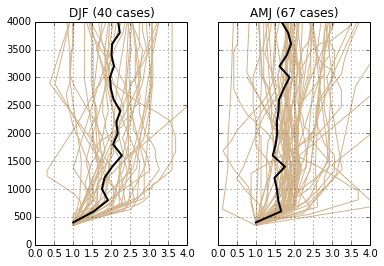

In [42]:
def compute_mean(h, s):
    ''' Compute a mean profile '''
    x = []
    y = []
    for hght in range(300,4301,200):
        vals = []
        for myh, mys in zip(h,s):
            for myhh, myss in zip(myh, mys):
                if myhh >= hght and myhh < (hght+200):
                    vals.append(myss)
        x.append( sum(vals) / float(len(vals)))
        y.append( hght + 100)
    return x, y
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots(1,2, sharey=True)

for i, (h,s) in enumerate(zip(ar_whght,ar_wsped)):
    if max(s) > 100:
        continue
    n = np.array(s) / s[0]
    ax[0].plot(n,h, color='tan')

x, y = compute_mean(ar_whght, ar_wsped)
ax[0].plot(np.array(x) / x[0],y, color='k', lw=2, zorder=2)
    
for i, (h,s) in enumerate(zip(ar_hght,ar_sped)):
    if max(s) > 100:
        continue
    n = np.array(s) / s[0]
    ax[1].plot(n,h, color='tan')

x, y = compute_mean(ar_hght, ar_sped)
ax[1].plot(np.array(x) / x[0],y, color='k', lw=2, zorder=2)
ax[1].grid(True)
ax[0].grid(True)
    
ax[0].set_ylim(0,4000)
ax[0].set_xlim(0,4)
ax[1].set_xlim(0,4)
ax[0].set_title("DJF (%s cases)" % (len(ar_whght),)) 
ax[1].set_title("AMJ (%s cases)" % (len(ar_hght),)) 

In [26]:
fig.savefig('test.ps')
import iemplot
iemplot.makefeature('test')